In [79]:
import time
import json

import pandas as pd
import numpy as np
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_squared_error, accuracy_score, plot_confusion_matrix, f1_score
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix

import stellargraph as sg
from stellargraph import datasets
from stellargraph.mapper import (
    CorruptedGenerator,
    FullBatchNodeGenerator,
    GraphSAGENodeGenerator,
    HinSAGENodeGenerator,
    Node2VecNodeGenerator,
    ClusterNodeGenerator,
)
from stellargraph.layer import GCN, DeepGraphInfomax, GraphSAGE, GAT, APPNP, HinSAGE, Dense

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Model, optimizers, losses, metrics

from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN, BorderlineSMOTE, KMeansSMOTE, SMOTENC, SVMSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.metrics import classification_report_imbalanced

from collections import Counter
import multiprocessing
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [2]:
import sys
sys.path.append('../')
import utils

n = 10000
v_sets, e_sets, core_targets, ext_targets, v_sample, e_sample = utils.load_for_jupyter(n)

Dataset already downloaded. Loading it from file system
LOADING DATA: 1.00 s
SUBSAMPLING: 0.06 s
PREPROCESSING: 0.05 s


In [3]:
v_sets['Account']

,Revenue Size Flag,CoreCaseGraphID,ExtendedCaseGraphID,Fraudolent
node_id,,,,
1502003,4,0.0,0.0,0
15020017,2,0.0,0.0,0
15020020,5,0.0,0.0,0
15020027,3,2844.0,0.0,1
15020029,4,0.0,0.0,0
...,...,...,...,...
15020148794,3,0.0,0.0,0
15020148808,5,0.0,0.0,0
15020148818,4,0.0,0.0,0


In [4]:
batch_size = 300
epochs = 35
# Use 70% of edges for training, the rest for testing:
train_size = 0.7
test_size = 0.3

In [5]:
# Initialize SG graph
G = sg.StellarDiGraph(v_sets, e_sets)

In [6]:
nodes_with_labels = v_sets.copy()

In [7]:
ext_targets.size

2808

In [8]:
print(G.info())

StellarDiGraph: Directed multigraph
 Nodes: 19045, Edges: 10000

 Node types:
  Account: [10938]
    Features: float32 vector, length 4
    Edge types: Account-money transfer->Account, Account-money transfer->Derived Entity
  Customer: [3395]
    Features: float32 vector, length 6
    Edge types: Customer-has account->Account, Customer-has address->Address, Customer-is similar->External Entity
  Derived Entity: [3105]
    Features: float32 vector, length 5
    Edge types: Derived Entity-is similar->External Entity, Derived Entity-money transfer->Account
  External Entity: [1197]
    Features: float32 vector, length 5
    Edge types: none
  Address: [410]
    Features: float32 vector, length 3
    Edge types: none

 Edge types:
    Account-money transfer->Account: [3194]
        Weights: range=[1, 500], mean=185.237, std=224.958
        Features: none
    Customer-has account->Account: [2970]
        Weights: all 1 (default)
        Features: none
    Account-money transfer->Derived Ent

In [9]:
# Split edges into train and test sets

train_ID, test_ID = model_selection.train_test_split(
    ext_targets, train_size=train_size, test_size=test_size, #stratify=ext_targets
)

In [10]:
# Select only nodes of type "Account" for prediction

train_ID = train_ID[train_ID.index.isin(v_sets['Account'].index)]
test_ID = test_ID[test_ID.index.isin(v_sets['Account'].index)]

In [11]:
# Convert targets labels in one-hot encoded features (optional, for categorical targets)

target_encoding = preprocessing.LabelBinarizer()
train_targets = target_encoding.fit_transform(train_ID)
test_targets = target_encoding.transform(test_ID)

In [12]:
train_ID.shape

(859, 1)

In [13]:
train_targets.shape

(859, 661)

In [14]:
# Choosing a 2 layer model with 8 nodes sampled in the first layer and 4 in the second.
num_samples = [8, 4]
# we can do 8*4 = 32x32 hidden layer size, since len(num_samples) defines 
# the number of hops (layers) in the HinSAGE model

In [15]:
'''
HinSAGENodeGenerator(G, batch_size, num_samples, head_node_type=None, schema=None, seed=None, name=None)

G = graph
batch_size = size of batch to return
num_samples = the number of samples per layer (hop) to take
head_node_type = the node type that will be given to the generator using the flow method. 
                  The model will expect this type.
                  If not given, it defaults to a single node type.
'''

generator = HinSAGENodeGenerator(
    G, 
    batch_size, 
    num_samples,
    head_node_type="Account"
)

In [16]:
# Flow

train_gen = generator.flow(train_ID.index, train_targets, shuffle=True)
test_gen = generator.flow(test_ID.index, test_targets)

In [17]:
generator.schema.schema

{'External Entity': [],
 'Derived Entity': [EdgeType(n1='Derived Entity', rel='is similar', n2='External Entity'),
  EdgeType(n1='Derived Entity', rel='money transfer', n2='Account')],
 'Account': [EdgeType(n1='Account', rel='money transfer', n2='Account'),
  EdgeType(n1='Account', rel='money transfer', n2='Derived Entity')],
 'Address': [],
 'Customer': [EdgeType(n1='Customer', rel='has account', n2='Account'),
  EdgeType(n1='Customer', rel='has address', n2='Address'),
  EdgeType(n1='Customer', rel='is similar', n2='External Entity')]}

In [18]:
hinsage_layer_sizes = [32, 32]
assert len(hinsage_layer_sizes) == len(num_samples)

In [19]:
# Dropout
# (must be tuned)

dropout = 0.5

In [20]:
hinsage = HinSAGE(
    layer_sizes=hinsage_layer_sizes,
    activations=['relu', 'softmax'],
    generator=generator, 
    bias=True,
    normalize="l2",
    dropout=dropout
)

In [21]:
x_inp, x_out = hinsage.in_out_tensors()

In [22]:
def run_deep_graph_infomax(base_model, generator, epochs):
    corrupted_generator = CorruptedGenerator(generator)
    gen = corrupted_generator.flow(G.nodes(node_type="Account"))
    infomax = DeepGraphInfomax(base_model, corrupted_generator)

    x_in, x_out = infomax.in_out_tensors()

    # Train DGI
    model = Model(inputs=x_in, outputs=x_out)
    model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=Adam(lr=1e-3))
    es = EarlyStopping(monitor="loss", min_delta=0, patience=15)
    history = model.fit(gen, epochs=epochs, verbose=1, callbacks=[es])
    sg.utils.plot_history(history)

    x_emb_in, x_emb_out = base_model.in_out_tensors()
    if generator.num_batch_dims() == 2:
        x_emb_out = tf.squeeze(x_emb_out, axis=0)

    #do TSNE here
    return x_emb_in, x_emb_out, model


Epoch 1/15
37/37 [==============================] - 8s 215ms/step - loss: 0.6782
Epoch 2/15
37/37 [==============================] - 8s 210ms/step - loss: 0.5509
Epoch 3/15
37/37 [==============================] - 8s 210ms/step - loss: 0.4881
Epoch 4/15
37/37 [==============================] - 8s 210ms/step - loss: 0.4524
Epoch 5/15
37/37 [==============================] - 8s 215ms/step - loss: 0.4329
Epoch 6/15
37/37 [==============================] - 8s 211ms/step - loss: 0.4199 1s - los
Epoch 7/15
37/37 [==============================] - 8s 216ms/step - loss: 0.4109 1s - loss
Epoch 8/15
37/37 [==============================] - 8s 211ms/step - loss: 0.3969
Epoch 9/15
37/37 [==============================] - 8s 211ms/step - loss: 0.3873
Epoch 10/15
37/37 [==============================] - 8s 211ms/step - loss: 0.3799
Epoch 11/15
37/37 [==============================] - 8s 213ms/step - loss: 0.3704
Epoch 12/15
37/37 [==============================] - 8s 211ms/step - loss: 0.3465 1s - l

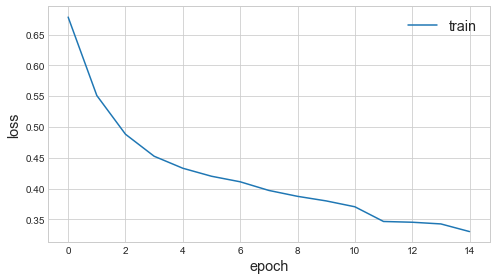

In [23]:
# Run Deep Graph Infomax

x_emb_in, x_emb_out, model = run_deep_graph_infomax(hinsage, generator, epochs=epochs)

In [24]:
emb_model = Model(inputs=x_emb_in, outputs=x_emb_out)
all_embeddings = emb_model.predict(
    #use a heterogeneous generator...
    generator.flow(G.nodes(node_type="Account"))
)

In [25]:
embeddings_2d = pd.DataFrame(
    TSNE(n_components=2).fit_transform(all_embeddings), 
    index=G.nodes(node_type="Account")
)

In [26]:
embeddings_2d.head()

,0,1
1502003,15.535662,22.726868
15020017,11.533812,-33.645798
15020020,57.434631,25.489361
15020027,-4.541763,7.856531
15020029,15.535662,22.726868


In [27]:
# Coloring based on ExtendedCaseGraphID
node_ids = G.nodes(node_type="Account").tolist()
ext_targets = v_sample.loc[[int(node_id) for node_id in node_ids]].ExtendedCaseGraphID 

label_map = {l: i*10 for i, l in enumerate(np.unique(ext_targets), start=10) if pd.notna(l)}
node_colours = [label_map[target] if pd.notna(target) else 0 for target in ext_targets]

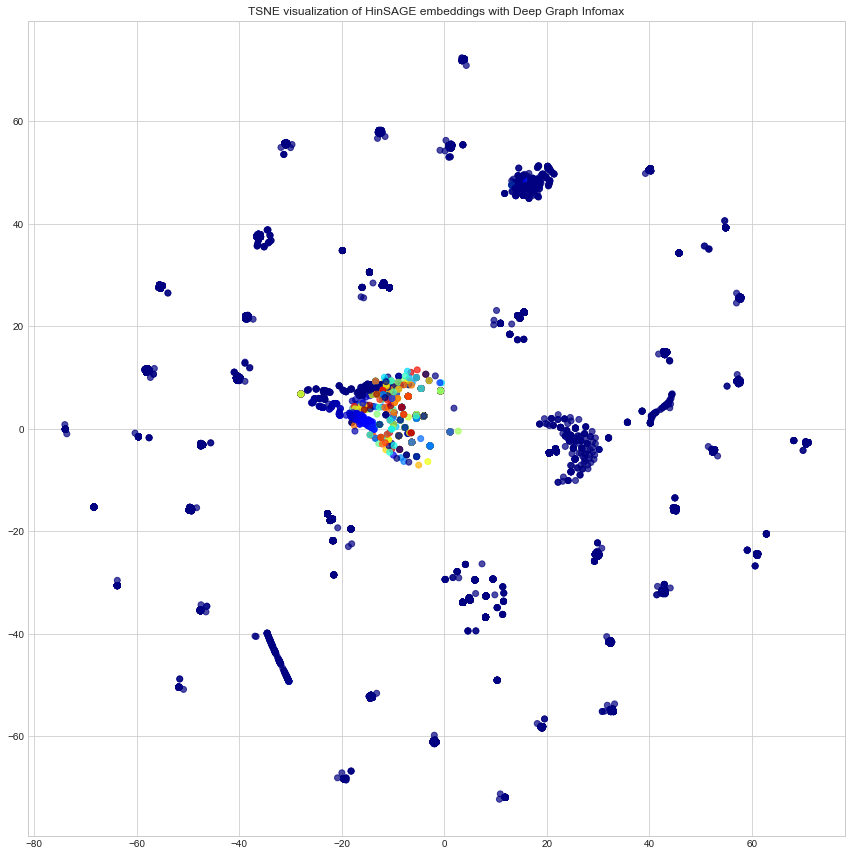

In [28]:
alpha = 0.7


fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(
    embeddings_2d[0],
    embeddings_2d[1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal")
plt.title("TSNE visualization of HinSAGE embeddings with Deep Graph Infomax")
plt.show()

In [29]:
# Coloring based on 'Fraudolent' flag:

ext_fraud = v_sets['Account'].loc[[int(node_id) for node_id in node_ids]].Fraudolent
label_map_fraud = {l: i*10000 for i, l in enumerate(np.unique(ext_fraud.values), start=1) if pd.notna(l)}
node_colours_fraud = [label_map_fraud[target] if pd.notna(target) else 0 for target in ext_fraud]

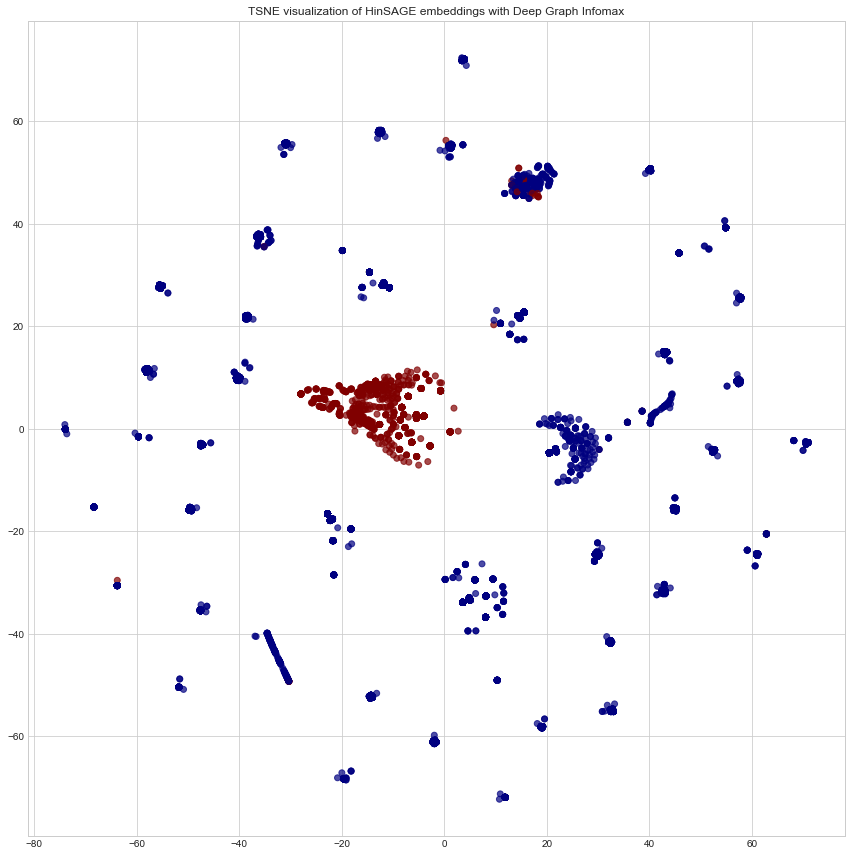

In [30]:
alpha = 0.7


fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(
    embeddings_2d[0],
    embeddings_2d[1],
    c=node_colours_fraud,
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal")
plt.title("TSNE visualization of HinSAGE embeddings with Deep Graph Infomax")
plt.show()

In [31]:
all_embeddings.shape

(10938, 32)

In [32]:
node_ids_full = np.concatenate((
    G.nodes(node_type='Account'), 
    G.nodes(node_type='Customer'), 
    G.nodes(node_type='Derived Entity')
)).tolist()

In [33]:
len(node_ids_full)

17438

In [34]:
len(np.concatenate((
    all_embeddings,
    all_embeddings
)))
#Perfect

21876

# Classification

In [90]:
# END-TO-END
# Maybe try with a softmax dense layer on top of hinsage to predict extendedcaseID?

In [35]:
# Classify 'Fraudolent' binary class based on embeddings

In [36]:
train_subjects, test_subjects = model_selection.train_test_split(
    ext_fraud, train_size=0.1, test_size=None
)

In [37]:
# 1 split dataset (v_sets) in training and test set
# 2 obtain embeddings of train and test set (using the already trained infomax results)
# 3 use classifier on train embeddings and corresponding train set.
# 4 evaluate on test set

In [38]:
train_gen = generator.flow(train_subjects.index)
test_gen = generator.flow(test_subjects.index)

train_embeddings = emb_model.predict(train_gen)
test_embeddings = emb_model.predict(test_gen)

In [39]:
lr = LogisticRegression(multi_class="auto", solver="lbfgs")
lr.fit(train_embeddings, train_subjects)

LogisticRegression()

In [40]:
y_pred = lr.predict(test_embeddings)
acc = (y_pred == test_subjects).mean()
print(f"Test Accuracy on binary fraudolent classification: {acc:.5f}")

Test Accuracy on binary fraudolent classification: 0.99573


In [41]:
unique, counts = np.unique(y_pred, return_counts=True)
dict(zip(unique, counts))

{'0': 8223, '1': 1622}

In [42]:
unique, counts = np.unique(test_subjects.values, return_counts=True)
dict(zip(unique, counts))

{'0': 8181, '1': 1664}

The classifier got 10 nodes wrong out of around 10k.

This proves that the embeddings are pretty good for identifying fraudolent nodes.

Now let's try to infer the core cases out of the fraudolent nodes.

In [43]:
# Now I can throw away all the nodes with Fraudolent flag = 0

In [44]:
fraudolent_accounts = pd.DataFrame({'ground_truth':test_subjects, 'predicted':y_pred})
fraudolent_accounts = fraudolent_accounts.loc[fraudolent_accounts['predicted'] == '1']
fraudolent_accounts = fraudolent_accounts.drop(['ground_truth'], axis=1)

In [45]:
fraudolent_accounts.shape

(1622, 1)

In [46]:
# Second part: Classification of fraudolent node embeddings by Case ID

In [47]:
# Extract IDs of nodes in fraudolent_accounts from ext_targets (since I removed the non-fraudolent nodes)
filter_ext_targets = ext_targets[ext_targets.index.isin(fraudolent_accounts.index.tolist())]

In [48]:
filter_ext_targets.shape

(1622,)

In [49]:
filter_ext_targets.value_counts()

0.0       504
2424.0      7
120.0       7
3974.0      6
3064.0      5
         ... 
3460.0      1
3580.0      1
1051.0      1
1553.0      1
1833.0      1
Name: ExtendedCaseGraphID, Length: 813, dtype: int64

In [73]:
filter_ext_targets.shape

(1622,)

The class imbalance problem was not solved, it was only sized down from 11000 nodes to about 1500.

Now I need to do undersampling and oversampling to train this classifier since the classes are too imbalanced.

-> Attempt #1 : SMOTE (Synthethic Minority Oversampling TEchnique)

-> Attempt #2: ADASYN

-> Attempt #3: XGBoost tuned for imbalanced class

In [50]:
# Baseline: logistic regression classifier on imbalanced data:

In [51]:
train_subjects, test_subjects = model_selection.train_test_split(
    filter_ext_targets, train_size=0.1, test_size=None
)

In [52]:
train_gen = generator.flow(train_subjects.index)
test_gen = generator.flow(test_subjects.index)

train_embeddings = emb_model.predict(train_gen)
test_embeddings = emb_model.predict(test_gen)

In [53]:
lr = LogisticRegression(multi_class="auto", solver="lbfgs")
lr.fit(train_embeddings, train_subjects)

LogisticRegression()

In [54]:
y_pred = lr.predict(test_embeddings)
acc = (y_pred == test_subjects).mean()
print(f"Test Accuracy on extended ID classification of fraudolent nodes: {acc:.5f}")

Test Accuracy on extended ID classification of fraudolent nodes: 0.31233


In [55]:
np.unique(y_pred)

array([0.])

In [56]:
# The logistic classifier can't distinguish between the imbalanced classes, as expected.

## SMOTE

In [83]:
X_train = train_embeddings
y_train = train_subjects

X_test = test_embeddings
y_test = test_subjects

In [58]:
y_train.value_counts()

0.0       48
2400.0     2
2634.0     2
2424.0     2
2981.0     2
          ..
991.0      1
1426.0     1
2100.0     1
3502.0     1
1053.0     1
Name: ExtendedCaseGraphID, Length: 107, dtype: int64

In [59]:
y_train.shape

(162,)

In [74]:
X_train.shape

(162, 32)

In [76]:
strategy = {l: 48 for i, l in enumerate(y_train.values)}
strategy[0.0] = 48
#oversample = SMOTE(k_neighbors=1)
oversample = RandomOverSampler(
    sampling_strategy=strategy
)

X_train, y_train = oversample.fit_resample(X_train, y_train)

In [75]:
'''counter = Counter(y_train)
for k, v in counter.items():
    per = v/len(y_train) * 100
    print('Class=%.0f, \t n=%d \t (%.3f%%)' % (k, v, per))
'''

print(f"No. of classes: {len(np.unique(y_train))}")

No. of classes: 107


In [63]:
lr = LogisticRegression(multi_class="auto", solver="lbfgs")
lr.fit(X_train, y_train)

LogisticRegression()

In [64]:
y_pred = lr.predict(test_embeddings)
acc = (y_pred == test_subjects).mean()
print(f"Test Accuracy on extended ID classification of fraudolent nodes: {acc:.5f}")

Test Accuracy on extended ID classification of fraudolent nodes: 0.00068


In [65]:
unique, counts = np.unique(y_pred, return_counts=True)
dict(zip(unique, counts))

{19.0: 20, 1083.0: 1440}

In [66]:
predicted_cases =pd.DataFrame({'ground_truth':test_subjects, 'predicted':y_pred})

In [67]:
f1_score(predicted_cases['ground_truth'], predicted_cases['predicted'], average='micro')

0.0006849315068493151

In [68]:
confusion_matrix = pd.crosstab(
    predicted_cases['ground_truth'],
    predicted_cases['predicted'],
    rownames=['Actual'],
    colnames=['Predicted'],
    margins=True
)
confusion_matrix

Predicted,19.0,1083.0,All
Actual,,,
0.0,11,445,456
3.0,1,0,1
10.0,1,0,1
19.0,1,0,1
29.0,1,0,1
...,...,...,...
3988.0,0,1,1
3994.0,0,2,2
3995.0,0,1,1


# Over/Under sampling & Classifier Selection

In [69]:
# reset dataset
X_train = train_embeddings
y_train = train_subjects

X_test = test_embeddings
y_test = test_subjects

In [70]:
classifiers = {
    'mnb': MultinomialNB(),
    'gnb': GaussianNB(),
    'svm1': SVC(kernel='linear'),
    'svm2': SVC(kernel='rbf'),
    'svm3': SVC(kernel='sigmoid'),
    'mlp1': MLPClassifier(),
    'mlp2': MLPClassifier(hidden_layer_sizes=[100, 100]),
    'ada': AdaBoostClassifier(),
    'dtc': DecisionTreeClassifier(),
    'rfc': RandomForestClassifier(),
    'gbc': GradientBoostingClassifier(),
    'lr': LogisticRegression(multi_class="auto", solver="lbfgs")
}

samplers = {
    #'smote': SMOTE(),
    'ros': RandomOverSampler(sampling_strategy='not majority'),
    #'adasyn': ADASYN(sampling_strategy='not majority'),
    #'b-smote': BorderlineSMOTE(),
    #'k-smote': KMeansSMOTE(),
    #'smtnc': SMOTENC(),
    #'svms': SVMSMOTE(),
    #'smtn': SMOTEENN(),
    #'smtet': SMOTETomek(),
}

In [71]:
f1_scores = dict()
for clf_name in classifiers:
    clf = classifiers[clf_name]
    print("\n")
    for smp in samplers:
        X_t, y_t = samplers[smp].fit_resample(X_train, y_train)
        clf.fit(X_t, y_t)
        y_pred = clf.predict(X_test)
        print(f"clf: {clf_name} - smp: {smp} - f1: {f1_score(y_pred, y_test, average='micro')}")
        f1_scores[clf_name] = f1_score(y_pred, y_test, average='micro')



clf: mnb - smp: ros - f1: 0.0013698630136986301


clf: gnb - smp: ros - f1: 0.015753424657534248


clf: svm1 - smp: ros - f1: 0.0013698630136986301


clf: svm2 - smp: ros - f1: 0.009589041095890411


clf: svm3 - smp: ros - f1: 0.002054794520547945


clf: mlp1 - smp: ros - f1: 0.0027397260273972603


clf: mlp2 - smp: ros - f1: 0.002054794520547945


clf: ada - smp: ros - f1: 0.007534246575342466


clf: dtc - smp: ros - f1: 0.00410958904109589


clf: rfc - smp: ros - f1: 0.00410958904109589


clf: gbc - smp: ros - f1: 0.007534246575342466


clf: lr - smp: ros - f1: 0.0006849315068493151


In [72]:
f1_scores

{'mnb': 0.0013698630136986301,
 'gnb': 0.015753424657534248,
 'svm1': 0.0013698630136986301,
 'svm2': 0.009589041095890411,
 'svm3': 0.002054794520547945,
 'mlp1': 0.0027397260273972603,
 'mlp2': 0.002054794520547945,
 'ada': 0.007534246575342466,
 'dtc': 0.00410958904109589,
 'rfc': 0.00410958904109589,
 'gbc': 0.007534246575342466,
 'lr': 0.0006849315068493151}